In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


# Overview

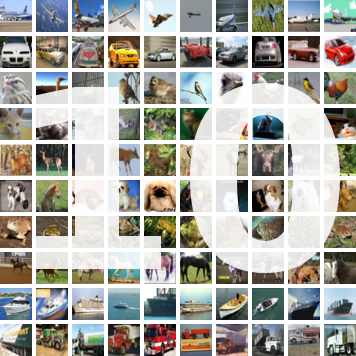

In this notebook we will use a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The task is pretty hard, as the images from the dataset are not that easy to clasify with great accuracy even for a person. But PyTorch let us build pretty easilly a CNN, whill is of great help.

# Imports

Let's start with out imports. We import a bounch of things from torch, some utils and some data for plotting.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Loading and prepparing the data

Load the data from disk, we will use the available PyTorch functionality for this.

In [3]:
dataset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python/", train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python/", train=False, download=False, transform=transforms.ToTensor())

Split the train data into train and validate, create data loaders and define the classes and the batch size constant.

In [4]:
batchSize = 200

trainset, validateset = random_split(dataset, [45000, 5000])

train = DataLoader(trainset, batchSize, shuffle=True)
validate = DataLoader(validateset, batchSize, shuffle=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# Display some of the images
Display some of the pictures, to verify everything is ok, and also it will make some good plots :)

First let's display the first batch of 200 images from the training set.

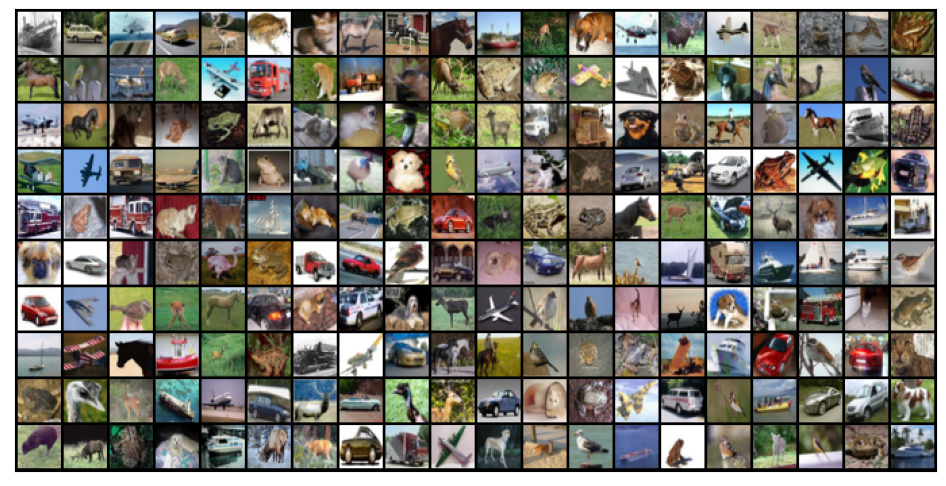

In [5]:
for images, labels in train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

Now let's display a few of the images a little bigger, also with a their lable as a title.

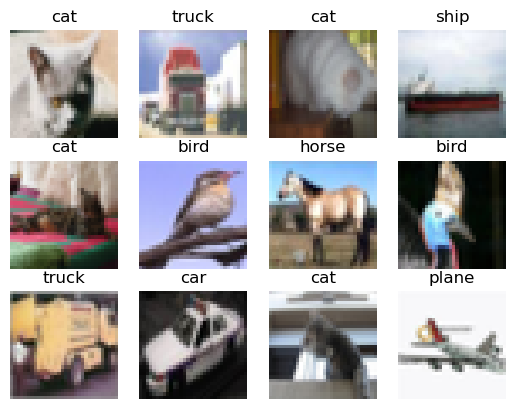

In [6]:
for i in range(0, 12):
    img, label = validateset[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

As you can see this is a pretty hard problem, as many of the images are hard for even a human. CNNs to the rescue!

# Creating the CNN Classification Model class

We will define a class that will serve as our classification model. We will levarage the functionality provided to us by PyTorch.

In [7]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(
            
            # here we define 3 channels as our inpur, 32 channels as the output, 
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch):
        # unpack the images and labels from the
        images, labels = batch

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

# Training the CNN classification model

We will first define an evaluation method, a train method and then we will train our model.

In [8]:
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [9]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    optimizer = optimizationFunction(model.parameters(), lr)

    for epoch in range(epochs):
        print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainingLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")

Now we will instantiate the model and performn an evaluation on it, before training the model. Because the weights of the model are randomly initliasied we have an accuracy of about 10% (100% devided by the number of classes). 

In [10]:
# instantiate the model
model = Cifar10Classifier()
# do an evaluation of the model on the tra
evaluateModel(model, validate)

{'loss': 2.3030247688293457, 'accuracy': 0.10119999945163727}

Now let's do the training of the model

In [11]:
%%time
trainModel(6, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

training epoch 0
after training epoch 0 we get results {'loss': 1.599267840385437, 'accuracy': 0.38360005617141724}
training epoch 1
after training epoch 1 we get results {'loss': 1.127974510192871, 'accuracy': 0.5864000916481018}
training epoch 2
after training epoch 2 we get results {'loss': 0.9412559270858765, 'accuracy': 0.6601999402046204}
training epoch 3
after training epoch 3 we get results {'loss': 0.8204888105392456, 'accuracy': 0.7085999846458435}
training epoch 4
after training epoch 4 we get results {'loss': 0.7589285373687744, 'accuracy': 0.7278000712394714}
training epoch 5
after training epoch 5 we get results {'loss': 0.6817948222160339, 'accuracy': 0.7585999369621277}
CPU times: user 39min 22s, sys: 2min 52s, total: 42min 14s
Wall time: 42min 21s


We trained for 6 epochs, with this type of network we can achieve an accuracy of about 0.75 - 0.8. In our case we got about 0.72 which is satisfactory. Training the model for more epoch will end up yielding smaller improvements, capping bellow 0.8.

# Predicting the imagge class with our trainned model

First predict the accuracy for the validation dataset and then the test dataset.

In [12]:
print(f"validation dataset accuracy: {evaluateModel(model, validate)}")

validation dataset accuracy: {'loss': 0.6817948222160339, 'accuracy': 0.7585999965667725}


In [13]:
print(f"test dataset accuracy: {evaluateModel(model, testLoader)}")

test dataset accuracy: {'loss': 0.7257897257804871, 'accuracy': 0.7502999901771545}


So we can see we have the accuracy and the loss pretty similar for the validation and test datasets. The accuracy of the test dataset is **0.5656**.

Let's define a new utility function to predict the label of an image based on the model.

In [14]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

Now we will plot maybe the most interesting image of the notebook, several images with the predicted and actual labels. Again we can see that the CIFAR-10 dataset is pretty hard, even for humans!

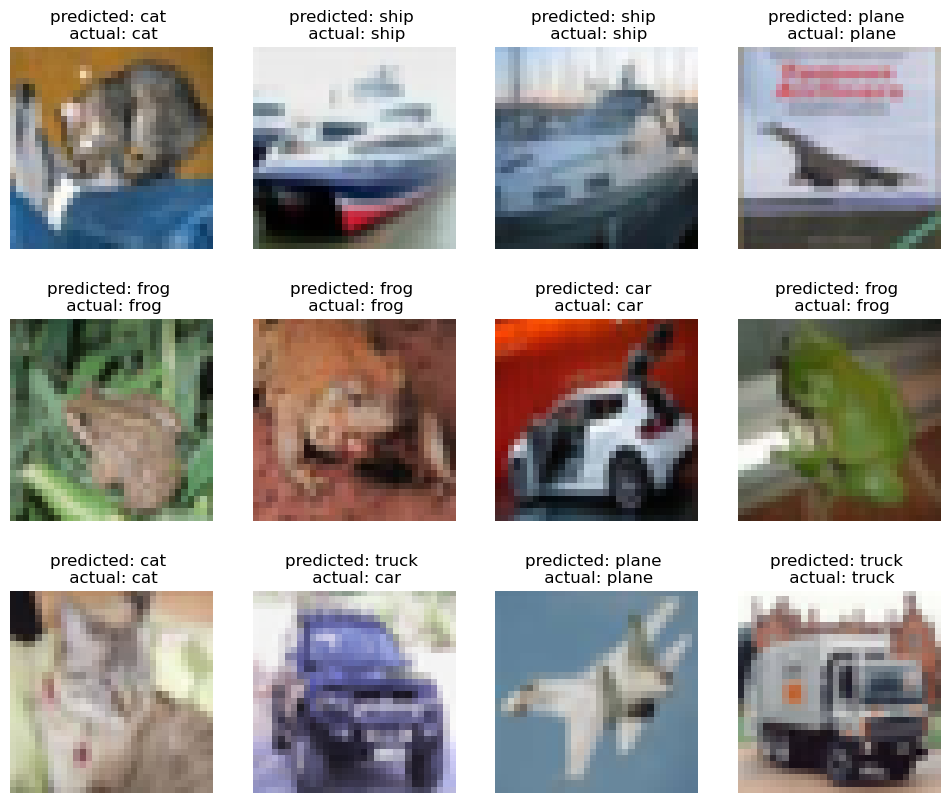

In [15]:

with torch.no_grad():
    
    plt.subplots(figsize=(12, 10))
    
    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)
        
        
        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))

# Confusion matrix

No classification problem is not complete without a confudion matrix, so let's make one!

In [16]:
predictions = np.empty((0, len(testset)), np.int32)
actualValues = np.empty((0, len(testset)), np.int32)

with torch.no_grad():
    for i in range(0, len(testset)):
        testImg, testLabel = testset[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)

<AxesSubplot:>

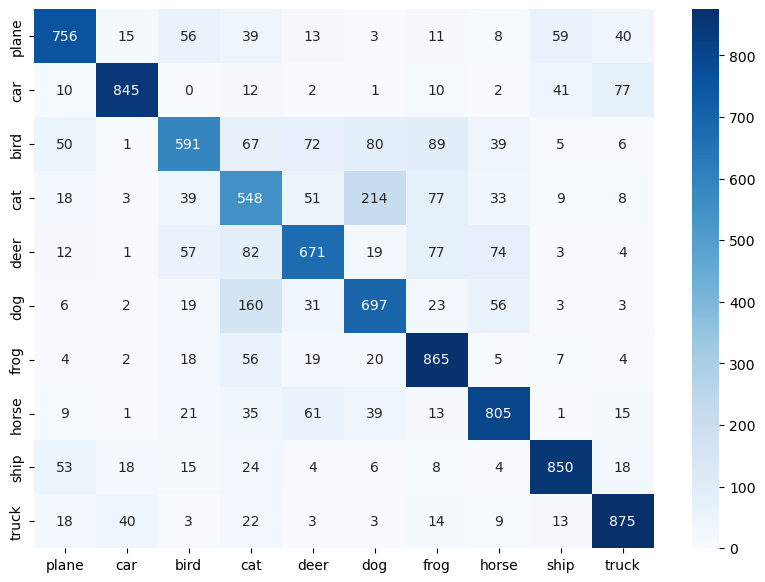

In [17]:
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')

Once again the confusion matrix does not dissapoint!

# Conclusion

The CIFAR-10 is a dificult data set to classify, but with CNNs we are up to the task! With PyTorch it is pretty easy to implement CNNs so our tasks is much easier.

Looking at the confusion matrix we can say that the classification of animals is the most deficult.